<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [973]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm,trange
import pdb
import inspect
import scipy.io
import copy

import scipy.stats, scipy.special
from scipy.special import digamma as Digamma
from scipy.special import gamma as Gamma

from numpy.random import gamma as Gammar
from numpy.random import beta as Beta
from numpy.random import multivariate_normal as Normal

In [2]:
def log(x):
    return np.log(x)

In [409]:
def logGamma(x):
    return np.log(Gamma(x))

In [4]:
def stirling(x):
    return np.sqrt(2*np.pi/x)*(x/np.e)**x

In [5]:
def IBP(alpha = 10, num_object = 20):
    n_init = np.random.poisson(alpha)
    Z = np.zeros(shape=(num_object,n_init),dtype = np.int32)
    Z[0,:] = 1
    K_plus = n_init
    for i in range(1,num_object):
        # Calculate probability of visiting past dishes
        Z[i,:] = Z.sum(axis = 0)/(i+1) > np.random.rand(1,K_plus)
        # Calculate the number of new dishes visited by customer i
        K_new = np.random.poisson(alpha/(i+1)) 
        Z=np.concatenate((Z,np.zeros(shape=(num_object,K_new),dtype = np.int32)), axis=1)
        Z[i,K_plus:K_plus+K_new] = 1
        # Update matrix size and dish popularity count
        K_plus = K_plus+K_new
    return Z, K_plus

In [891]:
# helper class for simpler function arguments and data storage
class params_set():
    def attrs_dict(self):
        return self.__dict__
    def print_attrs(self, key = None):
        if key == None:
            key = list(self.attrs_dict().keys())
        for k in key:
            print(k+": ",self.attrs_dict()[k])
    def set_attrs_dict(self, dic): # not useful unless for testing
        self.__dict__ = dic

In [892]:
data_dic = scipy.io.loadmat('data.mat')

In [893]:
X = scipy.io.loadmat('data.mat')['X']

In [922]:
N = model.N
K = model.K
D = model.D

alpha = model.alpha
sigma_A = model.sigma_A
sigma_n = model.sigma_n

# nu = model.nu
# tau = model.tau
# phi_mean = model.phi[0,:,:]
# phi_cov = model.phi[1,:,:]


In [923]:
def compute_auxiliary_q_and_lb(tau, k):
    tau = tau[:k,:]
    temp = Digamma(tau[:,1]) \
         + np.cumsum(np.insert(Digamma(tau[:,0]),0,0))[:-1] \
         - np.cumsum(Digamma(tau[:,0]+tau[:,1])) 
    q = np.exp(temp-temp.max())
    q = q/q.sum()
    lb = (q*(temp - log(q))).sum()
    return q, lb   

In [924]:
def compute_lower_bound(X, model): #  --- correct
    # following section 2.2 in VIBP derivation (eq.10)
    N = model.N
    K = model.K
    D = model.D
    
    alpha = model.alpha
    sigma_n = model.sigma_n
    sigma_A = model.sigma_A
    
    nu = model.nu
    tau = model.tau
    phi_mean = model.phi[0,:,:]
    phi_cov = model.phi[1,:,:]
    
    terms = [] # save terms seperately for debugging purpose
    
    # forth term (eq.18), for v   --- correct
    term4 = K*log(alpha) + (alpha - 1) \
                *(Digamma(tau[:,0]) - Digamma(tau.sum(axis=1))).sum()
    terms.append(term4)
    
    # fifth term (eq.19), for Z   --- correct
    term5 = 0
    for k in range(K):
        q, lb = compute_auxiliary_q_and_lb(tau, k+1)
        term5 += nu[:,k].sum()*(Digamma(tau[:k+1,0]) - Digamma(tau[:k+1,0]+tau[:k+1,1])).sum() \
                + (N-nu[:,k].sum())*lb
    terms.append(term5)
    
    # sixth term (eq.24), for A   --- correct
    term6 = -K*D/2*log(2*np.pi*sigma_A**2) \
            - 1/(2*sigma_A**2) * (phi_cov.sum() + (phi_mean**2).sum()) # need to confirm the last term (phi_mean**2).sum()
    terms.append(term6)
    
    # seventh term (eq.26), for likelihood   --- correct
    term7 = - N*D/2*(log(2*np.pi*sigma_n**2) ) \
            - 1/(2*sigma_n**2)*( (X**2).sum() \
                                   - 2*(nu*(X@phi_mean.T)).sum() \
                                   + ((nu@phi_mean)**2).sum() - (nu**2@phi_mean**2).sum() \
                                   + (nu*(np.ones_like(X)@(phi_cov + phi_mean**2).T)).sum() )  # need to confirm the last term (nu@(phi_cov + (phi_mean**2))).sum()
    terms.append(term7)
    
    # eighth term (eq.29), for entropy --- correct
    term8_4 = logGamma(tau[:,0]).sum() + logGamma(tau[:,1]).sum() - logGamma(tau.sum(axis=1)).sum()  - ((tau[:,0] - 1)*Digamma(tau[:,0])).sum() - ((tau[:,1] - 1)*Digamma(tau[:,1])).sum() + ((tau.sum(axis=1) - 2)*Digamma(tau.sum(axis=1))).sum()
#     approxiate term8_4 using Stirling's approximation
#     temp = 0
#     for i in range(tau.shape[0]):
#         temp += log( np.sqrt(2*np.pi*tau[i,0]*tau[i,1])/(tau[i,0]+tau[i,1])) \
#                 + tau[i,0]*log(tau[i,0]) + tau[i,1]*log(tau[i,1]) \
#                 - (tau[i,0] + tau[i,1])*log(tau[i,0] + tau[i,1])
#     term8_4 = temp \
#             - ((tau[:,0] - 1)*Digamma(tau[:,0])).sum() \
#             - ((tau[:,1] - 1)*Digamma(tau[:,1])).sum() \
#             + ((tau.sum(axis=1) - 2)*Digamma(tau.sum(axis=1))).sum()
    term8_5 = K*D/2*log(2*np.pi*np.e) + 1/2*log(phi_cov).sum()
    
    tmp_nu = nu + 0.5*(nu==0) - 0.5*(nu==1)
    term8_6 = -tmp_nu*log(tmp_nu) - (1-tmp_nu)*log(1-tmp_nu)
    term8_6 = ( term8_6 * (nu>0) * (nu<1) ).sum() 
    
    term8s = np.array([term8_4, term8_5, term8_6])
    term8 = term8s.sum()
    terms.append(term8)
    
    lower_bound = np.sum(terms)
    return lower_bound, terms

In [925]:
lbb, terms = compute_lower_bound(X, model)

In [926]:
lbb, terms

(-61723.58345250463,
 [0.0,
  -1280.7578904705629,
  -224.12755275098982,
  -60328.99166317382,
  110.29365389074492])

In [927]:
def update_phi(X, model): # --- correct
    N = model.N
    K = model.K
    D = model.D
    nu = model.nu
    phi_mean = model.phi[0,:,:]
    phi_cov = model.phi[1,:,:]
    for k in range(K):
        non_k_idx = np.delete(np.arange(K), k)
        mat_B = (1/sigma_A**2 + 1/sigma_n**2 * np.ones_like(X).T@nu[:,k]) # why the mask (ones_like in my case)?
        mat_C = X.T@nu[:,k]
        for n in range(N):
            mat_C -= nu[n,k] * (nu[n,non_k_idx].reshape(-1,1)*phi_mean[non_k_idx,:]).sum(axis = 0)
        mat_C = mat_C /sigma_n**2

        phi_cov[k,:] = 1/mat_B
        phi_mean[k,:] = mat_C/mat_B
    return phi_mean, phi_cov


In [989]:
def update_nu(X, model): # --- correct
    N = model.N
    K = model.K
    nu = model.nu
    phi_mean = model.phi[0,:,:]
    phi_cov = model.phi[1,:,:]
    tau = model.tau
    
    for k in range(K):
        _, lb = compute_auxiliary_q_and_lb(tau, k+1)
        var_theta_k = (Digamma(tau[:k+1,0]) - Digamma(tau[:k+1,:].sum(axis=1))).sum() - lb
        non_k_idx = np.delete(np.arange(K), k)
        for n in range(N):
            var_theta = var_theta_k - 1/(2*sigma_n**2) * ((phi_cov[k,:].sum() + (phi_mean[k,:]**2).sum()) \
                            - 2*(phi_mean[k,:].T@(X[n,:].T - (nu[n, non_k_idx].reshape(-1,1) * phi_mean[non_k_idx,:]).sum(axis=0) )) )
            nu[n,k] = max(0.00001, 1/(1+np.exp(-var_theta)) ) # var_theta can be too negative, lead to overflow
    return nu         
                                     

In [990]:
def update_tau(model):  # --- correct
    N = model.N
    K = model.K
    nu = model.nu
    tau = model.tau
    
    sum_n_nu = nu.sum(axis=0)
    N_minus_sum_n_nu = N - sum_n_nu
    for k in range(K):
        q,_ = compute_auxiliary_q_and_lb(tau, K)
        qs = np.zeros((K,K))
        for m in range(k,K):
            qs[m,:m+1] = q[:m+1]/q[:m+1].sum()
        
        tau[k,0] = alpha + sum_n_nu[k:].sum() \
                        + N_minus_sum_n_nu[k+1:]@qs[k+1:,k+1:].sum(axis=1) # need to confirm derivation  
        tau[k,1] = N_minus_sum_n_nu[k:]@qs[k:,k] + 1   # need to confirm derivation  
    return tau
        

In [992]:
def update_parameters(X, model):
    for j in np.random.permutation(3): # update in random order
        if j == 0:
            tau = update_tau(model)
            model.tau = tau
        elif j == 1:
            nu = update_nu(X, model)
            model.nu = nu
        else:
            phi_mean, phi_cov = update_phi(X, model)
            model.phi[0,:,:] = phi_mean
            model.phi[1,:,:] = phi_cov
    return model

In [1041]:
def search_heuristics(X, model):
    best_lb = model.lbs[-1]
    new_model = copy.deepcopy(model)
    best_model = new_model
    K = model.K
    
    for h in range(K):
        for l in np.delete(np.arange(K), h):
            new_model = move(model, h, l)
            for count in range(3):
                new_model = update_parameters(X, new_model)
            new_lb, _ = compute_lower_bound(X, new_model)
            if new_lb > best_lb:
                best_model = new_model
                best_lb = new_lb
    print('after heuristic search, lb becomes', best_lb)
    best_model.lbs[-1] = best_lb
    return best_model

In [1040]:
def move(model, h, l):
    new_model = copy.deepcopy(model)
    
    phi_mean = new_model.phi[0,:,:]
    phi_cov = new_model.phi[1,:,:]
    nu = new_model.nu
    
    r = np.random.randint(3)
    if r == 0:  # Let h = h - l, leave l alone
        phi_mean[h,:] = phi_mean[h,:] - phi_mean[l,:]
        nu[:,h] = nu[:,h] - nu[:,l]
        nu[nu[:,h] <= 0, h] = 0.001  # make sure it's larger than 0
    elif r == 1: # Let h = h + l, leave l alone
        phi_mean[h,:] = phi_mean[h,:] + phi_mean[l,:]
        nu[:,h] = nu[:,h] + nu[:,l]
        nu[nu[:,h] >= 1, h] = 0.999 # make sure it's smaller than 1
        phi_cov_avg = (phi_cov[h,:] + phi_cov[l,:])/2
        phi_cov[h,:] = phi_cov_avg
        phi_cov[l,:] = phi_cov_avg
    elif r == 2: # randomly reset h and l
        phi_mean[h,:] = 0.01*np.random.randn(phi_mean[h,:].shape[0])
        phi_mean[l,:] = 0.01*np.random.randn(phi_mean[l,:].shape[0])
        nu[:,h] = np.random.rand(nu[:,h].shape[0])
        nu[:,l] = np.random.rand(nu[:,l].shape[0])
        phi_cov_avg = (phi_cov[h,:] + phi_cov[l,:])/2
        phi_cov[h,:] = phi_cov_avg
        phi_cov[l,:] = phi_cov_avg
    
    new_model.phi[0,:,:] = phi_mean
    new_model.phi[1,:,:] = phi_cov
    new_model.nu = nu
    return new_model

In [1042]:
# initialize
# np.random.seed(123)
model = params_set() # save model parameters
hyper = params_set() # save hyper parameters
hyper.num_iter = 1000
hyper.logging_per = 100 # logging the model parameters per several iterations
hyper.logging_skip = 100 # skip the first several iterations
hyper.logging_count = int((hyper.num_iter - hyper.logging_skip)/hyper.logging_per + 1)
hyper.converge_iter = 5
hyper.search_heuristic = 'random'


model.N, model.D = 20, 16

model.alpha = data_dic['alpha'][0,0]

# model.sigma_A = 0.43
model.sigma_A = data_dic['sigma_a'][0,0]

# model.sigma_n = 0.1
model.sigma_n = data_dic['sigma_n'][0,0]


# hidden variables to be learned
# model.Z, model.K = IBP(alpha = model.alpha, num_object = model.N)
model.K = 6 # set maximum truncation level

# variational parameters
model.phi = np.random.rand(2, model.K, model.D) # Dim 0 for mean and dim 1 for var
                                                # same in doshi's code, assume independent
# model.phi = 0.6*np.ones((2, model.K, model.D) )

model.tau = np.random.rand(model.K, 2)
# model.tau = 0.8*np.ones((model.K, 2))

model.nu = np.random.rand(model.N, model.K)
# model.nu = 0.93*np.ones((model.N, model.K))

# for logging purpose
model.lbs = []
model.best_lb = 0
model.best = {}



In [1043]:
# start iteration

# for itr in range(10):
for itr in range(hyper.num_iter):
    print('='*20,'itr {}'.format(itr),'='*20)
    
    lb, lb_terms = compute_lower_bound(X, model)
    print('lb',lb)
    model.lbs.append(lb)
    
    if len(model.lbs) > hyper.converge_iter and np.std(model.lbs[-hyper.converge_iter:]) < 1e-4: # stop if converge
        print('converged!')
        break
    if model.best_lb < lb or model.best_lb == 0: # save the best model parameters
        model.best['tau'] = model.tau
        model.best['nu'] = model.nu
        model.best['phi'] = model.phi
    
    model = update_parameters(X, model)
    model = search_heuristics(X, model)
    
    


==================== itr 0 ====================
lb -44726.50023113657


/Users/joey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


after heuristic search, lb becomes -666.2817217835817
==================== itr 1 ====================
lb -666.2817217835817
after heuristic search, lb becomes -168.31075554539098
==================== itr 2 ====================
lb -168.31075554539098
after heuristic search, lb becomes 27.2648842970644
==================== itr 3 ====================
lb 27.2648842970644
after heuristic search, lb becomes 41.4828765557953
==================== itr 4 ====================
lb 41.4828765557953
after heuristic search, lb becomes 58.63217161615847
==================== itr 5 ====================
lb 58.63217161615847
after heuristic search, lb becomes 59.15336236289477
==================== itr 6 ====================
lb 59.15336236289477
after heuristic search, lb becomes 59.15439057853027
==================== itr 7 ====================
lb 59.15439057853027
after heuristic search, lb becomes 59.154430323074905
==================== itr 8 ====================
lb 59.154430323074905
after heuristic sear

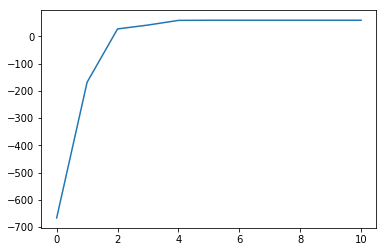

In [1044]:
plt.plot(model.lbs)

(20, 6)

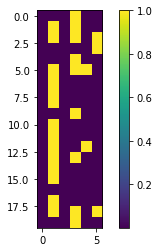

In [1045]:
plt.imshow(model.best['nu'])
plt.colorbar()
nu.shape

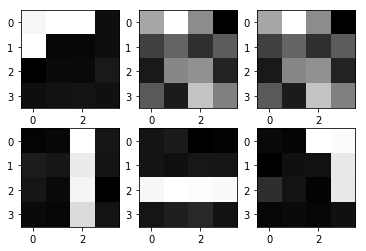

In [1036]:
for j in range(6):
    plt.subplot(2,3,1+j)
    plt.imshow(model.phi[0,j,:].reshape(4,4), cmap = 'gray')
plt.show()